<a href="https://colab.research.google.com/github/meghamkpatel/Skunks_Skool/blob/main/INFO_6105/SHAP/SHAP_Zomato_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Sci Eng Methods 
## Assignment 3 – Zomato_EDA

*Model Interpretability*


# Abstract

Zomato is an Indian multinational restaurant aggregator and food delivery company. 

Zomato provides information, menus and user-reviews of restaurants as well as food delivery options from partner restaurants in select cities. 
This dataset is comprised of information of food restraunts in Banglaore working with Zomato.

Reference: https://www.kaggle.com/datasets/pranavuikey/zomato-eda

The aim of the Notebook is to create interpret different models on the Zomato dataset. We will:
* Fit a linear model and interpret the regression coefficients

* Fit a tree-based model and interpret the nodes

* Use auto ml to find the best model

* Run SHAP analysis on the models from steps 1, 2, and 3,   interpret the SHAP values and compare them with the other model interpretability methods.

_________________________________________________________
###Getting our data

This dataset contains 51717 data values which is above GitHub's threshold of .csv files. Accordingly, we pull in the kaggle dataset directly using the kaggle library and my kaggle credentials.

In [1]:
#installing dependencies
!pip install plotly
!pip install shap
!pip install eli5
! pip install -q kaggle
#installing h2o
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 6.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 7.9 MB/s 
     |████████████████████████████████| 133 kB 21.4 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=fca6da16cd57efe571a561f78bedc6a030d6cc432b42282c54dc04e541458ae3
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that a

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
#importing all necessary libraries
%matplotlib inline  
import random, os, sys
import h2o
import pprint
import operator
import matplotlib
from sklearn.ensemble import RandomForestClassifier
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from tabulate import tabulate
from h2o.automl import H2OAutoML
from datetime import datetime
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import math
import shap

In [3]:
#making a directory for kaggle api
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
#downloading and reading the zomato dataset
! kaggle datasets list -s zomato # searching through kaggle with keyword 'zomato'
! kaggle datasets download -d pranavuikey/zomato-eda
!unzip zomato-eda.zip

ref                                                          title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
himanshupoddar/zomato-bangalore-restaurants                  Zomato Bangalore Restaurants                        89MB  2019-03-31 09:48:43          47542       1173  1.0              
shrutimehta/zomato-restaurants-data                          Zomato Restaurants Data                              5MB  2018-03-13 04:56:25          45509        625  0.7941176        
rishikeshkonapure/zomato                                     Zomato                                              89MB  2022-10-29 06:56:33           1551         49  1.0              
batjoker/zomato-restaurants-hyderabad                        Zomato Restaurants 

In [5]:
#Viewing data in the file 
data = pd.read_csv("zomato.csv")
data.shape
data.head()

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes                             phone  \
0          Yes        Yes  4.1/5    775    080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5    787                      080 41714161   
2          Yes         No  3.8/5    918                    +91 9663487993   
3           No         No  3.7/5     88                    +91 9620009302   
4           No         No  3.8/5    166  +91 8026612447\r\n+91 9901210005   

       location            rest_type  \
0  Banashankari        Casual Dining   
1  Banashankari        Casual Dining   
2  Banashankari  Cafe, Casual Dining   
3  Banashankari          Quick Bites   
4  Basavanagudi        Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3                                        Masala Dosa   
4                                Panipuri, Gol Gappe   

                         cuisines approx_cost(for two people)  \
0  North Indian, Mughlai, Chinese                         800   
1     Chinese, North Indian, Thai                         800   
2          Cafe, Mexican, Italian                         800   
3      South Indian, North Indian                         300   
4        North Indian, Rajasthani                         600   

                                        reviews_list menu_item  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []   
1  [('Rated 4.0', 'RATED\n  Had been here for din...        []   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...        []   
3  [('Rated 4.0', "RATED\n  Great food and proper...        []   
4  [('Rated 4.0', 'RATED\n  Very good restaurant ...        []   

  listed_in(type) listed_in(city)  
0          Buffet    Banashankari  
1          Buffet    Banashankari  
2          Buffet    Banashankari  
3          Buffet    Banashankari  
4          Buffet    Banashankari

Additionally, I have sampled a 2000 random points as an alternative for a local file and commented out the code to change the input to that file

In [6]:
#data = pd.read_csv('zomatoSample.csv')

##Cleaning Up Data


We must clean the dataset for this assignment to prevent any errors that would limit the full potential of AutoML.

###Dropping columns 

The columns phone, dish_liked, url, menu_item, and reviews_list help identify the restaurant but do not add characteristics to the dataset so we can drop them. 

In [7]:
data.drop(['url','address','phone','menu_item','dish_liked','reviews_list',"listed_in(city)"],axis = 1,inplace=True)
data.head(3)

name online_order book_table   rate  votes      location  \
0            Jalsa          Yes        Yes  4.1/5    775  Banashankari   
1   Spice Elephant          Yes         No  4.1/5    787  Banashankari   
2  San Churro Cafe          Yes         No  3.8/5    918  Banashankari   

             rest_type                        cuisines  \
0        Casual Dining  North Indian, Mughlai, Chinese   
1        Casual Dining     Chinese, North Indian, Thai   
2  Cafe, Casual Dining          Cafe, Mexican, Italian   

  approx_cost(for two people) listed_in(type)  
0                         800          Buffet  
1                         800          Buffet  
2                         800          Buffet

#### Renaming Column Headers
To better understand the data, let's first rename our column headers with appropriate units and descripter language. 

In [8]:
data.rename(columns={'name':'Restaurant','online_order': 'Online Ordering?', 'book_table':'Reservation Needed?','votes': 'Number of Votes','location':'City','rest_type': 'Restaurant Type', 'cuisines': 'Cuisines','rate':'Rating','approx_cost(for two people)':'Cost(Rupees)','listed_in(type)':'Meal Type'},inplace=True)
data.head(3)

Restaurant Online Ordering? Reservation Needed? Rating  \
0            Jalsa              Yes                 Yes  4.1/5   
1   Spice Elephant              Yes                  No  4.1/5   
2  San Churro Cafe              Yes                  No  3.8/5   

   Number of Votes          City      Restaurant Type  \
0              775  Banashankari        Casual Dining   
1              787  Banashankari        Casual Dining   
2              918  Banashankari  Cafe, Casual Dining   

                         Cuisines Cost(Rupees) Meal Type  
0  North Indian, Mughlai, Chinese          800    Buffet  
1     Chinese, North Indian, Thai          800    Buffet  
2          Cafe, Mexican, Italian          800    Buffet

###Missing Data

Imputing Missing Data:
We have three methods for imputing missing data. Using the median, dropping, and using machine learning. 

In [9]:
missing_list = data.columns[data.isna().any()].tolist() 
missing_count = []      
for i in missing_list:
  missing_count.append(sum(pd.isnull(data[str(i)])))

d = {'Missing_Column':missing_list,'Missing_Values':missing_count}
Missing_DF = pd.DataFrame(d)
Missing_DF["%_Missing"] = (Missing_DF['Missing_Values'] / data.shape[0]) * 100
Missing_DF

Missing_Column  Missing_Values  %_Missing
0           Rating            7775  15.033741
1             City              21   0.040606
2  Restaurant Type             227   0.438927
3         Cuisines              45   0.087012
4     Cost(Rupees)             346   0.669026

We see that most of our missing data is Rating. The median method in this case would not make sense for null values because rating for a restaurant should not be effected by the rest of the data. For example, a new restaurant that did not get the chance pass the inspection exam with rating "NEW" should not be replaced by a 3 star rating when there is an equal chance the restaurant could be of lower or higher quality. We could potentially explore Machine Learning but for the purposes of the training data we can justify using the dropping method for columns that are missing 5% or less of data since it is a very small percentage of missing data.
Note: I chose to drop NaN but other notebooks chose to use the mean to replace empty values.

In [10]:
data = data.dropna()
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30958 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Restaurant           30958 non-null  object
 1   Online Ordering?     30958 non-null  object
 2   Reservation Needed?  30958 non-null  object
 3   Rating               30958 non-null  object
 4   Number of Votes      30958 non-null  int64 
 5   City                 30958 non-null  object
 6   Restaurant Type      30958 non-null  object
 7   Cuisines             30958 non-null  object
 8   Cost(Rupees)         30958 non-null  object
 9   Meal Type            30958 non-null  object
dtypes: int64(1), object(9)
memory usage: 2.6+ MB


In [11]:
data.isnull().sum()

Restaurant             0
Online Ordering?       0
Reservation Needed?    0
Rating                 0
Number of Votes        0
City                   0
Restaurant Type        0
Cuisines               0
Cost(Rupees)           0
Meal Type              0
dtype: int64

#### Remove Duplicates
In case we have any duplicated rows, we remove duplicates. This is ensure there is no bias with repeating restaurants.

In [12]:
data.drop_duplicates(inplace=True)
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30958 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Restaurant           30958 non-null  object
 1   Online Ordering?     30958 non-null  object
 2   Reservation Needed?  30958 non-null  object
 3   Rating               30958 non-null  object
 4   Number of Votes      30958 non-null  int64 
 5   City                 30958 non-null  object
 6   Restaurant Type      30958 non-null  object
 7   Cuisines             30958 non-null  object
 8   Cost(Rupees)         30958 non-null  object
 9   Meal Type            30958 non-null  object
dtypes: int64(1), object(9)
memory usage: 2.6+ MB


### Clean up individual columns
Finally, we should check each variable and clean out data that does not make sense. This can either mean standardizing what "null" means in that context or removing random characters from changing data formats from object to integer



##### *Rating*

In [13]:
data['Rating'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

By displaying all unique values from the Rating column, we see that some entries contain "NEW", "nan", and "-" representing no ratings. We can standardize empty values to be nan. We also see that the Rating field contains strings of a floating number out of 5. To prepare for analyzing our data, we will extract the rating, setting the variable to be of type float. 

In [14]:
def clean(value):
    if value=='NEW' or value=='-':
        return np.nan
    else:
        value=str(value).split('/')
        value=value[0]
        return float(value)
    
data['Rating']=data['Rating'].apply(clean)
data['Rating'].head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30958 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Restaurant           30958 non-null  object 
 1   Online Ordering?     30958 non-null  object 
 2   Reservation Needed?  30958 non-null  object 
 3   Rating               29638 non-null  float64
 4   Number of Votes      30958 non-null  int64  
 5   City                 30958 non-null  object 
 6   Restaurant Type      30958 non-null  object 
 7   Cuisines             30958 non-null  object 
 8   Cost(Rupees)         30958 non-null  object 
 9   Meal Type            30958 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 2.6+ MB


In [15]:
data = data.dropna(subset=["Rating"])
data['Rating'] = [round(x) for x in data['Rating']]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
data['Rating'].unique()

array([4, 5, 3, 2])

##### *Location*


In [17]:
data['City'].unique()

array(['Banashankari', 'Basavanagudi', 'Mysore Road', 'Jayanagar',
       'Kumaraswamy Layout', 'Rajarajeshwari Nagar', 'Vijay Nagar',
       'Uttarahalli', 'JP Nagar', 'South Bangalore', 'City Market',
       'Bannerghatta Road', 'BTM', 'Kanakapura Road', 'Bommanahalli',
       'Electronic City', 'Wilson Garden', 'Shanti Nagar',
       'Koramangala 5th Block', 'Richmond Road', 'HSR',
       'Koramangala 7th Block', 'Bellandur', 'Sarjapur Road',
       'Marathahalli', 'Whitefield', 'East Bangalore', 'Old Airport Road',
       'Indiranagar', 'Koramangala 1st Block', 'Frazer Town', 'MG Road',
       'Brigade Road', 'Lavelle Road', 'Church Street', 'Ulsoor',
       'Residency Road', 'Shivajinagar', 'Infantry Road',
       'St. Marks Road', 'Cunningham Road', 'Race Course Road',
       'Commercial Street', 'Vasanth Nagar', 'Domlur',
       'Koramangala 8th Block', 'Ejipura', 'Jeevan Bhima Nagar',
       'Old Madras Road', 'Seshadripuram', 'Kammanahalli',
       'Koramangala 6th Block', 'Ma

In [18]:
data['City'].value_counts(ascending=False)

BTM                      2100
Indiranagar              1583
Koramangala 5th Block    1554
Whitefield               1537
HSR                      1480
                         ... 
Yelahanka                   4
West Bangalore              3
Rajarajeshwari Nagar        2
Nagarbhavi                  1
Peenya                      1
Name: City, Length: 92, dtype: int64

Looking at the breakdown of cities we see no typos or errors and can proceed.

##### *Cost*


In [19]:
data['Cost(Rupees)'].unique()

array(['800', '300', '600', '700', '550', '500', '450', '650', '400',
       '900', '200', '750', '150', '850', '100', '1,200', '350', '250',
       '950', '1,000', '1,500', '1,300', '199', '1,100', '1,600', '230',
       '130', '1,700', '1,350', '2,200', '1,400', '2,000', '1,800',
       '1,900', '180', '330', '2,500', '2,100', '3,000', '2,800', '3,400',
       '50', '40', '1,250', '3,500', '4,000', '2,400', '2,600', '1,450',
       '70', '3,200', '240', '6,000', '1,050', '2,300', '4,100', '120',
       '5,000', '3,700', '1,650', '2,700', '4,500', '80'], dtype=object)

Examining the unique values of Cost, we can see that the cost is stored as text with type object. We can correct the type to integer so that we can later model the variables.





In [20]:
data = data.dropna()

In [21]:
def money(value):
    value=str(value)
    if ',' in value:
        value=value.replace(',','')
        return int(value)
    else:
        return int(value)

data['Cost(Rupees)']=data['Cost(Rupees)'].apply(money)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29638 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Restaurant           29638 non-null  object
 1   Online Ordering?     29638 non-null  object
 2   Reservation Needed?  29638 non-null  object
 3   Rating               29638 non-null  int64 
 4   Number of Votes      29638 non-null  int64 
 5   City                 29638 non-null  object
 6   Restaurant Type      29638 non-null  object
 7   Cuisines             29638 non-null  object
 8   Cost(Rupees)         29638 non-null  int64 
 9   Meal Type            29638 non-null  object
dtypes: int64(3), object(7)
memory usage: 2.5+ MB


##### *Booking*


In [23]:
data['Reservation Needed?'].unique()

array(['Yes', 'No'], dtype=object)

Booking has no typos so we can proceed.

##### *Online Order*


In [24]:
data['Online Ordering?'].unique()

array(['Yes', 'No'], dtype=object)

Online Ordering has no typos so we can proceed.

##### *Restaurant Type*


In [25]:
data['Restaurant Type'].unique()

array(['Casual Dining', 'Cafe, Casual Dining', 'Quick Bites',
       'Casual Dining, Cafe', 'Cafe', 'Quick Bites, Cafe',
       'Cafe, Quick Bites', 'Delivery', 'Mess', 'Dessert Parlor',
       'Bakery, Dessert Parlor', 'Pub', 'Bakery', 'Takeaway, Delivery',
       'Fine Dining', 'Beverage Shop', 'Sweet Shop', 'Bar',
       'Dessert Parlor, Sweet Shop', 'Bakery, Quick Bites',
       'Sweet Shop, Quick Bites', 'Kiosk', 'Food Truck',
       'Quick Bites, Dessert Parlor', 'Beverage Shop, Quick Bites',
       'Beverage Shop, Dessert Parlor', 'Takeaway', 'Pub, Casual Dining',
       'Casual Dining, Bar', 'Dessert Parlor, Beverage Shop',
       'Quick Bites, Bakery', 'Microbrewery, Casual Dining', 'Lounge',
       'Bar, Casual Dining', 'Food Court', 'Cafe, Bakery', 'Dhaba',
       'Quick Bites, Sweet Shop', 'Microbrewery',
       'Food Court, Quick Bites', 'Quick Bites, Beverage Shop',
       'Pub, Bar', 'Casual Dining, Pub', 'Lounge, Bar',
       'Dessert Parlor, Quick Bites', 'Food Court, 

In [26]:
data['Restaurant Type'].value_counts(ascending=False)

Quick Bites                   9492
Casual Dining                 7151
Cafe                          2420
Dessert Parlor                1309
Delivery                      1054
                              ... 
Bakery, Food Court               2
Food Court, Beverage Shop        2
Bakery, Beverage Shop            1
Quick Bites, Kiosk               1
Dessert Parlor, Food Court       1
Name: Restaurant Type, Length: 87, dtype: int64

The Restaurant type has lots of values with multiple values for one restaurant. We can simplify the types to general group for better analysis.

In [27]:
def typeSimplify(value):
    value = str(value)
    if 'Sweet' in value or 'Dessert' in value or 'Confectionery' in value:
        return 'Dessert'
    elif 'Quick Bites' in value:
      return 'Quick Bites'
    elif 'Bar' in value or 'Microbrewery' in value:
      return 'Bar'
    elif 'Bakery' in value:
      return 'Bakery'
    elif 'Casual Dining' in value:
      return 'Casual Dining'
    elif 'Fine Dining' in value:
      return 'Fine Dining'
    elif 'Food Court' in value:
      return 'Street Food'
    elif 'Fast Food' in value:
      return 'Fast Food'
    elif 'Cafe' in value:
      return 'Cafe'
    elif 'North Indian' in value:
      return 'North Indian'
    elif 'South Indian' in value:
      return 'South Indian'
    else:
        return value
    
data['Restaurant Type']=data['Restaurant Type'].apply(typeSimplify)
data['Restaurant Type'].head(10)

0    Casual Dining
1    Casual Dining
2    Casual Dining
3      Quick Bites
4    Casual Dining
5    Casual Dining
6    Casual Dining
7    Casual Dining
8             Cafe
9             Cafe
Name: Restaurant Type, dtype: object

In [28]:
data['Restaurant Type'].unique()

array(['Casual Dining', 'Quick Bites', 'Cafe', 'Delivery', 'Mess',
       'Dessert', 'Pub', 'Bakery', 'Takeaway, Delivery', 'Fine Dining',
       'Beverage Shop', 'Bar', 'Kiosk', 'Food Truck', 'Takeaway',
       'Lounge', 'Street Food', 'Dhaba', 'Club', 'Bhojanalya'],
      dtype=object)

In [29]:
data['Restaurant Type'].isnull().sum()

0

##### *Meal Type*


In [30]:
data['Meal Type'].unique()

array(['Buffet', 'Cafes', 'Delivery', 'Desserts', 'Dine-out',
       'Drinks & nightlife', 'Pubs and bars'], dtype=object)

In [31]:
data['Meal Type'].value_counts()

Delivery              13504
Dine-out              10867
Desserts               2031
Cafes                  1136
Drinks & nightlife      877
Buffet                  655
Pubs and bars           568
Name: Meal Type, dtype: int64

Meal Type has no typos so we can proceed.

##### *Cuisines*


In [32]:
data['Cuisines'].unique()

array(['North Indian, Mughlai, Chinese', 'Chinese, North Indian, Thai',
       'Cafe, Mexican, Italian', ..., 'Tibetan, Nepalese',
       'North Indian, Street Food, Biryani',
       'North Indian, Chinese, Arabian, Momos'], dtype=object)

In [33]:
data['Cuisines'].value_counts()

North Indian                                1518
North Indian, Chinese                       1339
South Indian                                 851
Bakery, Desserts                             455
Biryani                                      410
                                            ... 
South Indian, Mangalorean, Chinese             1
Fast Food, Andhra                              1
Kerala, Biryani, North Indian, Chettinad       1
North Indian, Street Food, Fast Food           1
North Indian, Chinese, Arabian, Momos          1
Name: Cuisines, Length: 2367, dtype: int64

Cuisines have multiple values for one restaurant with repeating keywords but they show has different categories. We can simplify this to general groups for better analysis. 

In [34]:
data['Cuisines'].isnull().sum()

0

In [35]:
def cuisineSimplify(value):
    value = str(value)
    if 'Italian' in value or 'Pizza' in value:
        return 'Italian'
    elif 'African' in value:
      return 'African'
    elif 'Continental' in value:
      return 'Continental'
    elif "Mughlai" in value or 'Middle Eastern' in value or 'Biryani' in value or 'Arabian' in value or 'Turkish' in value:
      return 'Middle Eastern'
    elif 'Burger' in value or 'American' in value or 'Salad' in value or 'Sandwich' in value:
      return 'American'
    elif 'Indian' in value and 'Chinese' in value:
      return 'Asian Fusion'
    elif 'Thai' in value or 'Japanese' in value or 'Asian' in value or 'Chinese' in value or 'Tibetan' in value or 'Momo' in value:
      return 'Asian'
    elif 'Mexican' in value:
      return 'Mexican'
    elif 'Street Food' in value:
      return 'Street Food'
    elif 'Fast Food' in value:
      return 'Fast Food'
    elif 'Cafe' in value:
      return 'Cafe'
    elif 'North Indian' in value or 'Rajasthani' in value or "Gujarati" in value or 'Bengali' in value:
      return 'North Indian'
    elif 'South Indian' in value or 'Kerala' in value or 'Bengali' in value or 'Andhra' in value or 'Maharashtrian':
      return 'South Indian'
    elif 'Mediterranean' in value:
      return 'Mediterranean'
    elif 'Sweet' in value or 'Dessert' in value or 'Confectionery' in value or 'Mithai' in value:
      return 'Dessert'
    elif 'Cafe' in value:
      return 'Cafe'
    else:
        return value
    
data['Cuisines']=data['Cuisines'].apply(cuisineSimplify)
data['Cuisines'].head(10)


0    Middle Eastern
1      Asian Fusion
2           Italian
3      North Indian
4      North Indian
5      North Indian
6      Asian Fusion
7           Italian
8           Italian
9           Italian
Name: Cuisines, dtype: object

In [36]:
data['Cuisines'].unique()

array(['Middle Eastern', 'Asian Fusion', 'Italian', 'North Indian',
       'Cafe', 'Continental', 'Fast Food', 'American', 'South Indian',
       'Asian', 'Street Food', 'African', 'Mexican'], dtype=object)

##### *Restaurant*

In [37]:
data.drop(['Restaurant'],axis = 1,inplace=True)

##### *Number of Votes*

In [38]:
data = data.dropna(subset=['Number of Votes'])

In [39]:
data['Number of Votes'].unique()

array([ 775,  787,  918, ..., 4957, 2382,  843])

In [40]:
ALOT = 1e6
data['Number of Votes'] = [max(min(x, ALOT), -ALOT) for x in data['Number of Votes']]

##Data transforming, Feature creation and Analysis

In [41]:
data = data.dropna()

In [42]:
data.replace([np.inf, -np.inf], 0, inplace=True)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29638 entries, 0 to 51716
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Online Ordering?     29638 non-null  object
 1   Reservation Needed?  29638 non-null  object
 2   Rating               29638 non-null  int64 
 3   Number of Votes      29638 non-null  int64 
 4   City                 29638 non-null  object
 5   Restaurant Type      29638 non-null  object
 6   Cuisines             29638 non-null  object
 7   Cost(Rupees)         29638 non-null  int64 
 8   Meal Type            29638 non-null  object
dtypes: int64(3), object(6)
memory usage: 2.3+ MB


In [44]:
data_clean = data #making a copy so we don't lose all that progress!

In [45]:
data_clean['Reservation Needed?'] = data_clean['Reservation Needed?'].map({'Yes': 1, 'No': 0})

In [46]:
data_clean['Online Ordering?'] = data_clean['Online Ordering?'].map({'Yes': 1, 'No': 0})

In [47]:
X = data_clean.drop(['Rating'],axis=1)
Y = data_clean['Rating']

catagorical_features = ['City', 'Restaurant Type', 'Cuisines', 'Meal Type']
numerical_features = [c for c in X.columns if c not in catagorical_features]
cat = [([c], [OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)


It is usually considered to be highly correlated if the VIF value is higher than 5. None of the values we were looking at show a VIF value of 5 so we can assume there is no multicollinearly. A large vif in the constant indicates that the (slope) explanatory variables have also a large constant component. An example would be when a variable has a large mean but only a small variance. 

#Linear Regression

In [48]:
#Using OLS for finding the p value to check the significant features
import statsmodels.api as sm
from sklearn.model_selection import  train_test_split
from sklearn import datasets, linear_model

data_clean = data_clean.dropna(subset=['Rating'])

#Spliting data into Training 76.5%, Validation set 13.5% and Test set 10%
X_t, X_test, y_t, y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.15, random_state=1)

preprocessed_X_train = mapper.fit_transform(X_train)
preprocessed_X_train = sm.add_constant(preprocessed_X_train)

model = sm.OLS(y_train, preprocessed_X_train, axis =1).fit()

# Print out the statistics
model.summary()

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     518.5
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        05:43:03   Log-Likelihood:                -13894.
No. Observations:               22672   AIC:                         2.781e+04
Df Residuals:                   22663   BIC:                         2.788e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.8110      0.012    316.844      0.000       3.787       3.835
Online Ordering?        0.0541      0.003     17.539      0.000       0.048       0.060
Reservation Needed?     0.0489      0.004     12.450      0.000       0.041       0.057
Number of Votes         0.1054      0.003     31.976      0.000       0.099       0.112
Cost(Rupees)            0.0584      0.004     13.794      0.000       0.050       0.067
City                -5.055e-05      0.000     -0.442      0.659      -0.000       0.000
Restaurant Type        -0.0065      0.001    -11.446      0.000      -0.008      -0.005
Cuisines                0.0038      0.001      4.215      0.000       0.002       0.006
Meal Type              -0.0064      0.003     -2.504      0.012      -0.011      -0.001
==============================================================================
Omnibus:                     2048.850   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2647.042
Skew:                          -0.827   Prob(JB):                         0.00
Kurtosis:                       3.256   Cond. No.                         189.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
#Compute VIF data for each independent variable
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["features"] = preprocessed_X_train.columns
vif["vif_Factor"] = [variance_inflation_factor(preprocessed_X_train.values, i) for i in range(preprocessed_X_train.shape[1])]
vif.head(10)

features  vif_Factor
0                const   16.439729
1     Online Ordering?    1.079364
2  Reservation Needed?    1.753220
3      Number of Votes    1.235039
4         Cost(Rupees)    2.036943
5                 City    1.028115
6      Restaurant Type    1.287198
7             Cuisines    1.037189
8            Meal Type    1.076453

According to the low p-value and high t-statistic for a majority of the data, we can say that the relationship between rating and the number of votes,cost, and need for reservation is significant in addition to other categorical variables. We will further drill down which fields are exactly useful in predicing ratings in a cleaner way with AutoML



Similarly, we can convert our catagorical variables to numerical ones by creating a new column for each group with a binary value of 1 if that value belongs to that entry (0 if not).

In [50]:
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(preprocessed_X_train,y_train)

LinearRegression()

In [51]:
# Make predictions using the training set
y_pred = regr.predict(preprocessed_X_train)
# The mean squared error
print('Mean squared error: %.2f'% mean_squared_error(y_train, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_train, y_pred))
r2 = r2_score(y_train,y_pred)
print('R^2 score on training set =',r2)


Mean squared error: 0.20
Coefficient of determination: 0.15
R^2 score on training set = 0.15471522950463446


##SHAP Intrepretation

In [52]:
explainer = shap.Explainer(regr, preprocessed_X_train)
preprocessed_X_test = mapper.fit_transform(X_test)
preprocessed_X_test = sm.add_constant(preprocessed_X_test)
shap_values = explainer(preprocessed_X_test)

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [53]:
shap.initjs()

In [54]:
def sample_feature_importance(idx, type='condensed'):
    if type == 'condensed':
        return shap.plots.force(shap_values[idx])
    elif type == 'waterfall':
        return shap.plots.waterfall(shap_values[idx])
    else:
        return "Return valid visual ('condensed', 'waterfall')"

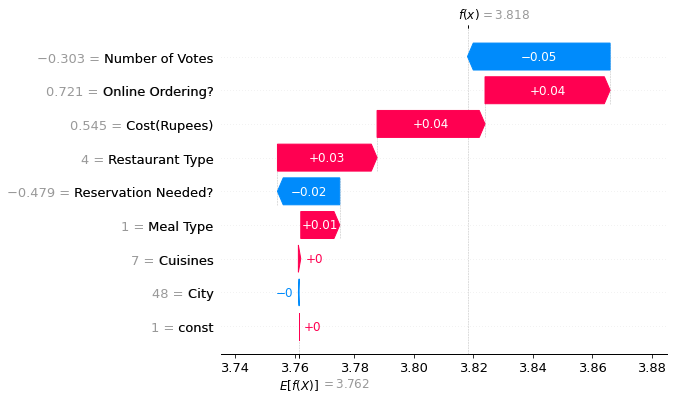

In [55]:
sample_feature_importance(0, 'waterfall')

In [ ]:
shap.initjs()
sample_feature_importance(0, 'condensed')


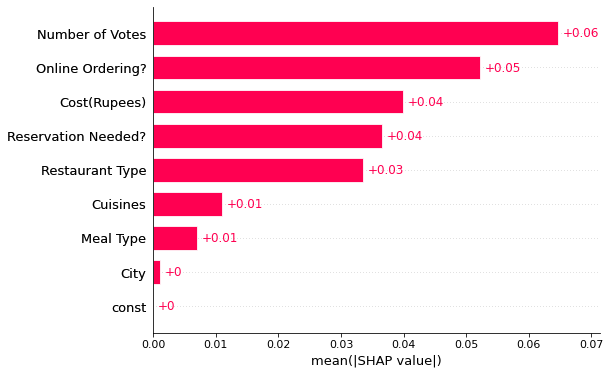

In [57]:
shap.plots.bar(shap_values)


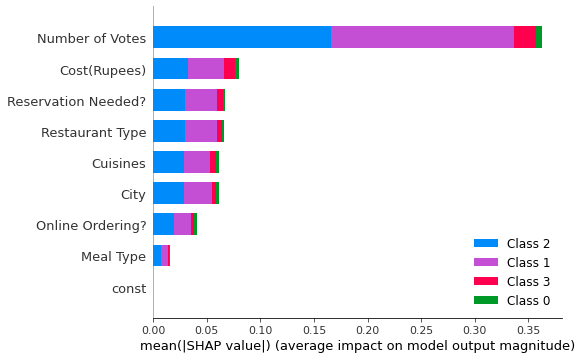

In [ ]:
shap.summary_plot(shap_values, preprocessed_X_test)

In [ ]:
# plot the SHAP values for the 1st observation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], preprocessed_X_test.iloc[1,:])

In [ ]:
# plot the SHAP values for the 2nd observation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][2,:], preprocessed_X_test.iloc[2,:])

In [ ]:
# plot the SHAP values for the 3rd observation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][3,:], preprocessed_X_test.iloc[3,:])

In [ ]:
# plot the SHAP values for the 4th observation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][4,:], preprocessed_X_test.iloc[4,:])

In [ ]:
# plot the SHAP values for the 5th observation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][5,:], preprocessed_X_test.iloc[5,:])

In [ ]:
# plot the SHAP values for the 6th observation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][6,:], preprocessed_X_test.iloc[6,:])

In [ ]:
# plot the SHAP values for the 7th observation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][7,:], preprocessed_X_test.iloc[7,:])

In [ ]:
# plot the SHAP values for the 8th observation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][8,:], preprocessed_X_test.iloc[8,:])

#Random Forest

In [58]:
X = data_clean.drop(['Rating'],axis=1)
Y = data_clean['Rating']

catagorical_features = ['City', 'Restaurant Type', 'Cuisines', 'Meal Type']
numerical_features = [c for c in X.columns if c not in catagorical_features]
cat = [([c], [OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)
#Spliting data into Training 76.5%, Validation set 13.5% and Test set 10%
X_t, X_test, y_t, y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.15, random_state=1)

preprocessed_X_train = mapper.fit_transform(X_train)
preprocessed_X_train = sm.add_constant(preprocessed_X_train)
model = RandomForestClassifier()
model.fit(preprocessed_X_train, y_train)




In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


RandomForestClassifier()

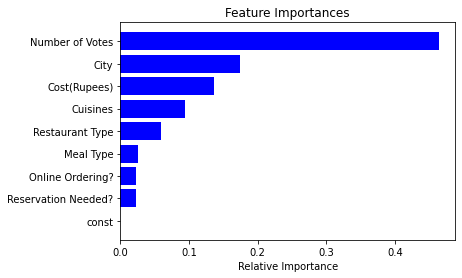

In [84]:
importances = model.feature_importances_
indices = np.argsort(importances)
features = preprocessed_X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [59]:
# Make predictions using the testing set
y_pred = model.predict(preprocessed_X_train)

In [60]:
from sklearn import metrics
# The mean squared error
print('Mean squared error: %.2f'% mean_squared_error(y_train, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_train, y_pred))
r2 = r2_score(y_train,y_pred)
print('R^2 score on training set =',r2)

Mean squared error: 0.00
Coefficient of determination: 0.99
R^2 score on training set = 0.9865401807248287


In [61]:
# Make predictions using the testing set
y_pred = model.predict(preprocessed_X_test)

In [62]:
# Model Accuracy, how often is the classifier correct?
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8029689608636977


##SHAP Intrepretation

In [88]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(preprocessed_X_test)

In [96]:
shap.initjs()

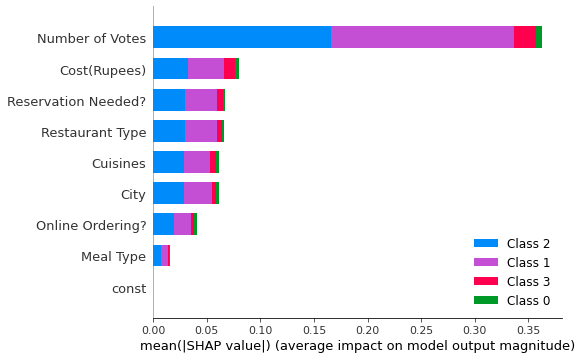

In [90]:
shap.summary_plot(shap_values, preprocessed_X_test)

In [98]:
# plot the SHAP values for the 1st observation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], preprocessed_X_test.iloc[1,:])

In [99]:
# plot the SHAP values for the 2nd observation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][2,:], preprocessed_X_test.iloc[2,:])

In [100]:
# plot the SHAP values for the 3rd observation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][3,:], preprocessed_X_test.iloc[3,:])

In [101]:
# plot the SHAP values for the 4th observation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][4,:], preprocessed_X_test.iloc[4,:])

In [102]:
# plot the SHAP values for the 5th observation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][5,:], preprocessed_X_test.iloc[5,:])

In [103]:
# plot the SHAP values for the 6th observation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][6,:], preprocessed_X_test.iloc[6,:])

In [104]:
# plot the SHAP values for the 7th observation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][7,:], preprocessed_X_test.iloc[7,:])

In [105]:
# plot the SHAP values for the 8th observation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][8,:], preprocessed_X_test.iloc[8,:])

In [106]:
def sample_feature_importance(idx, type='condensed'):
    if type == 'condensed':
        return shap.plots.force(shap_values[idx])
    elif type == 'waterfall':
        return shap.plots.waterfall(shap_values[idx])
    else:
        return "Return valid visual ('condensed', 'waterfall')"

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1], preprocessed_X_test)

# AutoML

##Initializing H2O


We must first install H2O and start the software.

In [67]:
min_mem_size=6 
run_time=333

In [68]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

6


In [69]:
#installing dependencies
!pip install eli5
!pip install -q kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
h2o.init(strict_version_check=False) # start h2o

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpmokz_mkv
  JVM stdout: /tmp/tmpmokz_mkv/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpmokz_mkv/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ----------------------------------
H2O_cluster_uptime:         07 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.38.0.3
H2O_cluster_version_age:    11 days
H2O_cluster_name:           H2O_from_python_unknownUser_501ypo
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.172 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.8.15 final
--------------------------  ----------------------------------

In [71]:
# set this to True if interactive (matplotlib) plots are desired
interactive = True
if not interactive: matplotlib.use('Agg', warn=False)
import matplotlib.pyplot as plt

In [72]:
#Viewing data 
data = h2o.H2OFrame(data_clean)
data.shape
data.describe()
data.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:29638
Cols:9

Online Ordering?    Reservation Needed?    Rating               Number of Votes     City          Restaurant Type    Cuisines        Cost(Rupees)       Meal Type
-------  ------------------  ---------------------  -------------------  ------------------  ------------  -----------------  --------------  -----------------  -----------
type     int                 int                    int                  int                 enum          enum               enum            int                enum
mins     0.0                 0.0                    2.0                  0.0                                                                  40.0
mean     0.648019434509751   0.17929684864025913    3.7513664889668608   425.3797827113847                                                    634.0447398609892
maxs     1.0                 1.0                    5.0                  16832.0                                                              6000.0
sigma    0.4775960041068574  0.3836071607362359     0.48789440532137324  1007.2929150656364                                                   480.9124985000013
zeros    10432               24324                  0                    19                                                                   0
missing  0                   0                      0                    0                   0             0                  0               0                  0
0        1.0                 1.0                    4.0                  775.0               Banashankari  Casual Dining      Middle Eastern  800.0              Buffet
1        1.0                 0.0                    4.0                  787.0               Banashankari  Casual Dining      Asian Fusion    800.0              Buffet
2        1.0                 0.0                    4.0                  918.0               Banashankari  Casual Dining      Italian         800.0              Buffet
3        0.0                 0.0                    4.0                  88.0                Banashankari  Quick Bites        North Indian    300.0              Buffet
4        0.0                 0.0                    4.0                  166.0               Basavanagudi  Casual Dining      North Indian    600.0              Buffet
5        1.0                 0.0                    4.0                  286.0               Basavanagudi  Casual Dining      North Indian    600.0              Buffet
6        0.0                 0.0                    4.0                  8.0                 Mysore Road   Casual Dining      Asian Fusion    800.0              Buffet
7        1.0                 1.0                    5.0                  2556.0              Banashankari  Casual Dining      Italian         600.0              Cafes
8        1.0                 0.0                    4.0                  324.0               Banashankari  Cafe               Italian         700.0              Cafes
9        1.0                 0.0                    4.0                  504.0               Banashankari  Cafe               Italian         550.0              Cafes
[29638 rows x 9 columns]

Online Ordering?    Reservation Needed?    Rating    Number of Votes  City          Restaurant Type    Cuisines          Cost(Rupees)  Meal Type
------------------  ---------------------  --------  -----------------  ------------  -----------------  --------------  --------------  -----------
                 1                      1         4                775  Banashankari  Casual Dining      Middle Eastern             800  Buffet
                 1                      0         4                787  Banashankari  Casual Dining      Asian Fusion               800  Buffet
                 1                      0         4                918  Banashankari  Casual Dining      Italian                    800  Buffet
                 0                      0         4                 88  Banashankari  Quick Bites        North Indian               300  Buffet
                 0                      0         4                166  Basavanagudi  Casual Dining      North Indian               600  Buffet
                 1                      0         4                286  Basavanagudi  Casual Dining      North Indian               600  Buffet
                 0                      0         4                  8  Mysore Road   Casual Dining      Asian Fusion               800  Buffet
                 1                      1         5               2556  Banashankari  Casual Dining      Italian                    600  Cafes
                 1                      0         4                324  Banashankari  Cafe               Italian                    700  Cafes
                 1                      0         4                504  Banashankari  Cafe               Italian                    550  Cafes
[10 rows x 9 columns]

##Predicting Rating

Now that we have initialized H2O with the zomato dataset, should first split the values into training and test datasets for verification.

In [73]:
train, test = data.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])

In [74]:
# assign target and inputs for logistic regression
y = 'Rating'
X = [name for name in train.columns if name != y]
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
print(y)
print(X)

Rating
['Online Ordering?', 'Reservation Needed?', 'Number of Votes', 'City', 'Restaurant Type', 'Cuisines', 'Cost(Rupees)', 'Meal Type']


In [75]:
aml = H2OAutoML(max_runtime_secs=run_time,exclude_algos = ['DeepLearning'])

Using AutoML, pass in training and testing datasets as well as the predictor values to predict Rating.

In [76]:
aml.train(x=X,y=y,training_frame=train, validation_frame=test)  # Change training_frame=train

AutoML progress: |
05:57:27.608: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

██████████████████
05:59:02.357: GLM_1_AutoML_1_20221205_55727 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException: Index 135 out of bounds for length 135

█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_1_AutoML_1_20221205_55727

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.05966730302415303
RMSE: 0.2442689153866145
LogLoss: 0.22416707561520183
Null degrees of freedom: 10017
Residual degrees of freedom: 10010
Null deviance: 13795.129984993828
Residual deviance: 4491.411527026184
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3     4     5    Error      Rate
---  ----  ----  ---  ---------  ------------
0    21    42    0    1          63 / 63
0    2189  354   0    0.139206   354 / 2,543
0    91    7138  0    0.0125882  91 / 7,229
0    0     52    131  0.284153   52 / 183
0    2301  7586  131  0.0558994  560 / 10,018

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.944101
2    0.993711
3    0.99461
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.09262501069089747
RMSE: 0.3043435734345272
LogLoss: 0.3126385028113374
Null degrees of freedom: 7326
Residual degrees of freedom: 7319
Null deviance: 10127.335628841078
Residual deviance: 4581.404620197339
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3     4     5    Error      Rate
---  ----  ----  ---  ---------  -----------
0    8     42    0    1          50 / 50
0    1351  516   0    0.276379   516 / 1,867
0    214   5064  0    0.0405457  214 / 5,278
0    0     53    79   0.401515   53 / 132
0    1573  5675  79   0.113689   833 / 7,327

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.886311
2    0.992357
3    0.993449
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.08605148054853974
RMSE: 0.29334532644741373
LogLoss: 0.28762645725941943
Null degrees of freedom: 22310
Residual degrees of freedom: 22292
Null deviance: 30934.551832806206
Residual deviance: 12834.467775829813
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3     4      5    Error      Rate
---  ----  -----  ---  ---------  --------------
85   21    50     0    0.455128   71 / 156
5    4136  1502   0    0.267057   1,507 / 5,643
7    901   15159  24   0.0579206  932 / 16,091
0    0     60     361  0.142518   60 / 421
97   5058  16771  385  0.11519    2,570 / 22,311

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.88481
2    0.996549
3    0.999552
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.881848  0.00331014  0.884178      0.883409      0.877221      0.884889      0.879545
auc                      nan       0           nan           nan           nan           nan           nan
err       

In [77]:
print(aml.get_leaderboard().head(20))

model_id                                                  mean_per_class_error    logloss      rmse        mse
StackedEnsemble_BestOfFamily_1_AutoML_1_20221205_55727                0.230656   0.287626  0.293345  0.0860515
GBM_1_AutoML_1_20221205_55727                                         0.238232   0.290592  0.292895  0.0857872
XGBoost_1_AutoML_1_20221205_55727                                     0.429277   0.354536  0.33086   0.109468
[3 rows x 5 columns]



In [ ]:
gbmmodel = h2o.get_model(aml.leaderboard[1,'model_id'])

In [80]:
perf = gbmmodel.model_performance(test)
perf

ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.10418530327982513
RMSE: 0.32277748260965344
LogLoss: 0.33751756755069373
Mean Per-Class Error: 0.4285061338011858
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3     4     5    Error      Rate
---  ----  ----  ---  ---------  -------------
6    7     37    0    0.88       44 / 50
0    1178  689   0    0.369041   689 / 1,867
0    294   4983  1    0.0558924  295 / 5,278
0    0     54    78   0.409091   54 / 132
6    1479  5763  79   0.147673   1,082 / 7,327

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.852327
2    0.995223
3    0.999454
4    1

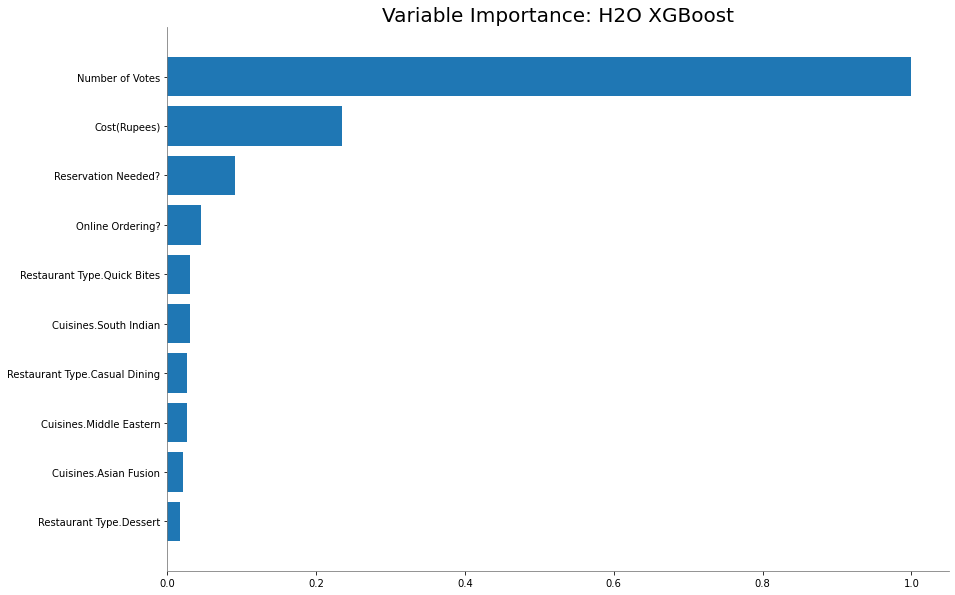

<Figure size 432x288 with 0 Axes>

In [81]:
gbmmodel.varimp_plot()

In [83]:
gbm_shap_values = shap.KernelExplainer(gbmmodel.predict,test)


TypeError: ignored

In [ ]:
shap.summary_plot(gbm_shap_values, test)